# Lab Assignment Four: Extending Logistic Regression 
## Rupal Sanghavi, Omar Roa

## Business Case

This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a "young person" would be interested in shopping at a large shopping center. We were not given details about what a "large" shopping center, but searching online for malls led us to the Avion Shopping Park in Ružinov, Slovakia. It has an area of 103,000m<sup>2</sup> and is the largest shopping mall in Slovakia (https://www.avion.sk/sk-sk/about-the-centre/fakty-a-cisla). 

Slovakia is in the lower half of European nations by size (28/48 - https://en.wikipedia.org/wiki/List_of_European_countries_by_area) and is very mountainous, making real estate space a precious commodity. This information would be of great interest to any commercial devlopment firm deciding on where to build their next shopping center or place of business. This could also help other parties trying to purchase real estate for youth-orientated construction (parks, recreation centers).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import accuracy_score
from scipy.special import expit
import time
import math
from memory_profiler import memory_usage

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target_classifier = 'Shopping centres'
df = pd.read_csv('responses.csv', sep=",")

## Define and Prepare Class Variables 

In [2]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [3]:
df_cleaned_classifier.isnull().sum().max()

20

In [4]:
df_fixed.shape

(1008, 173)

Our dataset (1010 rows and 150 columns) was mostly ordinal data as numbers (preferences ranked 1-5) . We also had some ordinal data as strings. 

e.g.
How much time do you spend online?: No time at all - Less than an hour a day - Few hours a day - Most of the day

We first removed any rows which contained NaN values for our target classifer, Shopping centres. Afterwards we imputed mean values for any NaN values in other features. We decided to impute due to the fact that there were not many NaN values in our features compared to the size of our data set. (At most was 20 for a feature, as shown above). We then one-hot encoded any string object, which created extra features.

We are left with numerical values for our features and a size of 1008 x 173

## Divide Data into Training and Testing

In [5]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


We are using Stratified Shuffle Splits so we can get a good random mix of training and testing data. We want to split and randommize our data to prevent overfitting our model. Our split uses a 20/80 split for testing and training. This gives us a significant representation of data for training and testing. Upon further research, splitting our testing data into testing and validation seems further appropriate, but we are not implementing that for our work.

Further down in our work, we are using Principal Component Analysis (via a Pipeline object) to reduce the number of features. 

## Creating One-Versus-All Logistic Regression Classifier
### Note: Each class allows a parameter for L1, L2, or both to be chosen in its gradient method

In [6]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001,reg=0):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.iterations = 0
        self.reg = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.reg == 0):
            gradient[1:] += 2 * self.w_[1:] * self.C
        elif(self.reg == 1):
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        else:
            gradient[1:] += 2 * self.w_[1:] * self.C
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        #gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    def _get_l1_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        return gradient
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 54 µs, sys: 1e+03 ns, total: 55 µs
Wall time: 58.9 µs


In [7]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
from scipy.optimize import OptimizeResult

import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad,C):
        wnew = w + grad*eta
        yhat = expit(X @ wnew)>0.5
        return np.sum((y-yhat)**2) + C*np.sum(wnew**2)
     
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
      

CPU times: user 61 µs, sys: 1 µs, total: 62 µs
Wall time: 67 µs


In [8]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.reg == 0):
            gradient[1:] += 2 * self.w_[1:] * self.C
        elif(self.reg == 1):
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        else:
            gradient[1:] += 2 * self.w_[1:] * self.C
            gradient[1:] += np.sign(self.w_[1:]) * self.C
        #gradient[1:] += 2 * self.w_[1:] * self.C
        #gradient[1:] += np.sign(self.w_[1:]) * self.C
        return gradient
    
    
# slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

# slr.fit(X,y)

# yhat = slr.predict(X)
# print(slr)
# print('Accuracy of: ',accuracy_score(y,yhat))      

CPU times: user 42 µs, sys: 1e+03 ns, total: 43 µs
Wall time: 47 µs


In [9]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    @staticmethod
    def objective_function(w,X,y,C,reg):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C,reg):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if(reg == 0):
            gradient[1:] += 2 * w[1:] * C
        elif(reg == 1):
            gradient[1:] += np.sign(w[1:]) * C
        else:
            gradient[1:] += 2 * w[1:] * C
            gradient[1:] += np.sign(w[1:]) * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        result = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C,self.reg), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False,
                            retall=True)
        self.iterations = len(result)
        #print("Iterations: ", self.iterations)
        #print("iterations: ", self.iterations)
        self.w_ = self.w_.reshape((num_features,1))
    def getIterations(self):
        return self.iterations
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 64.1 µs


We created the result (with parameter retall=True) variable to hold fmin_bfgs 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html

based on the description for  retall

retall : bool, optional
Return a list of results at each iteration if True.

We return the length of the list for the iterations.

EDIT: We realized that we are not getting iterations correctly and were not able to get iterations for our implementation.

## Ability to choose between optimization techniques

In [10]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=None,reg=0):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimization = optimization
        self.reg = reg
        self.params = {}

        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            #hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            if(self.optimization == "BFGSBinaryLogisticRegression"):
                #self.iters = 10
                hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C,self.reg)
                #print("Iterations: ",hblr.getIterations())

            elif(self.optimization == "StochasticLogisticRegression"):
                #self.iters = 2000 #1000
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C,self.reg)
            else:
                #self.iters = 100
                #self.C = 0.001
                hblr = LineSearchLogisticRegression(self.eta,self.iters,self.C,self.reg)

            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
    def get_params(self,deep=False):
        #return self.params
        return dict(C=self.C,eta=self.eta,iterations=self.iters, optimization=self.optimization)

    def set_params(self,**kwds):
        print(kwds)
        self.C = kwds['C']


## Varying Optimization Techniques, Etas, Iterations, and L1/L2

In [11]:
# run logistic regression and vary some parameters

from sklearn import metrics as mt
with np.errstate(all='ignore'):
    # first we create a reusable logisitic regression object
    #   here we can setup the object with different learning parameters and constants

    optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
    #optimizations = ["BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression"]
    etas = [0.1, 0.1, 0.001]
    iters = [10, 5000, 150]
    regs = [0,1,2]

    for optimization,eta,iter_,reg in zip(optimizations,etas,iters,regs):
        lr_clf = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization,reg=reg) # get object


        # now we can use the cv_object that we setup before to iterate through the 
        #    different training and testing sets. Each time we will reuse the logisitic regression 
        #    object, but it gets trained on different data each time we use it.

        iter_num=0
        # the indices are the rows used for training and testing in each iteration
        for train_indices, test_indices in cv_object.split(X,y): 
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = (X[train_indices])
            y_train = y[train_indices]

        #     print(X_train)
        #     print(y_train)

            X_test = (X[test_indices])
            y_test = y[test_indices]

    #         st = time.time()

            lr_clf.fit(X_train,y_train)  # train object
    #         t = (time.time() -st)
    #         lr_clf_times.append(t)

            lr_clf.fit(X_train,y_train)

            # train the reusable logisitc regression model on the training data
            y_hat = lr_clf.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat+1)
    #         lr_clf_accuracies.append(acc)
    #         cost_accuracies.append([acc])

            conf = mt.confusion_matrix(y_test,y_hat+1)
            print("====Iteration",iter_num," ====")
            if(reg == 0):
                label = "L1"
            elif(reg == 1):
                label = "L2"
            else:
                label = "L1 and L2"
            print('For ',optimization,' eta: ',eta, "Iterations: ",iter_,"Regularization: ",label,' : Accuracy of: ',acc)

            #print("accuracy", acc )
            print("confusion matrix\n",conf)
            iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

====Iteration 0  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.40099009901
confusion matrix
 [[ 7 10  6  3  0]
 [ 4 11  3  1  4]
 [ 5 10 15 11  8]
 [ 1  4 12 18 15]
 [ 2  2  9 11 30]]
====Iteration 1  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.40099009901
confusion matrix
 [[14  5  7  2  0]
 [ 7  6  9  6  4]
 [ 7  5 22 11  7]
 [ 3  3 15 21 11]
 [ 0  1  7 11 18]]
====Iteration 2  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.371287128713
confusion matrix
 [[ 9 13  7  2  0]
 [ 7 13  5  9  3]
 [11  7 15  9  7]
 [ 2  0 11 18 14]
 [ 2  3  4 11 20]]
====Iteration 0  ====
For  StochasticLogisticRegression  eta:  0.1 Iterations:  5000 Regularization:  L2  : Accuracy of:  0.207920792079
confusion matrix
 [[ 0  0  0  4 16]
 [ 0  0  0 11 20]
 [ 0  0  0 23 31]
 [ 0  0  0 31 19]
 [ 0  0  0 36 11]]
====Iteration 1  ====
Fo

While varying between Steepest Descent, Stochastic Gradient Descent, and Newton’s Method, the regularization parameters L1, L2, and L1/L2, iterations from 10,150,5000, and etas 0.1 or 0.001, we have found our optimal combination is BFGS, an eta of 0.1, 10 iterations, and L1 Regularization. The combinations with higher accuracies have greater amount of non-zero numbers in their confusion matrices. As the values along the diagonals of the confusion matrices indicate accurate predictions, this makes sense. For Stochastic Logistic Regression, we have around two to three target classes with zeroes in columns which shows that there are no accurate predictions for that target class, perhaps due to fewer instances for them.

## With Pipelining PCA

In [12]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
#optimizations = ["BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression","BFGSBinaryLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]
regs = [0,1,2]
components = 90
pca = PCA(n_components=components)

with np.errstate(all='ignore'):
    for optimization,eta,iter_,reg in zip(optimizations,etas,iters,regs):
        mglr = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization,reg=reg) # get object
        lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)]) # get object


        # now we can use the cv_object that we setup before to iterate through the 
        #    different training and testing sets. Each time we will reuse the logisitic regression 
        #    object, but it gets trained on different data each time we use it.

        iter_num=0
        # the indices are the rows used for training and testing in each iteration
        for train_indices, test_indices in cv_object.split(X,y): 
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = (X[train_indices])
            y_train = y[train_indices]

        #     print(X_train)
        #     print(y_train)

            X_test = (X[test_indices])
            y_test = y[test_indices]

    #         st = time.time()

            lr_clf.fit(X_train,y_train)  # train object
    #         t = (time.time() -st)
    #         lr_clf_times.append(t)

            lr_clf.fit(X_train,y_train)

            # train the reusable logisitc regression model on the training data
            y_hat = lr_clf.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat+1)
    #         lr_clf_accuracies.append(acc)
    #         cost_accuracies.append([acc])

            conf = mt.confusion_matrix(y_test,y_hat+1)
            print("====Iteration",iter_num," ====")
            if(reg == 0):
                label = "L1"
            elif(reg == 1):
                label = "L2"
            else:
                label = "L1 and L2"
            print('For ',optimization,' eta: ',eta, "Iterations: ",iter_,"Regularization: ",label,' : Accuracy of: ',acc)

            #print("accuracy", acc )
            print("confusion matrix\n",conf)
            iter_num+=1
            print("Accurate predictions",np.sum(np.diagonal(conf)))


        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

====Iteration 0  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.252475247525
confusion matrix
 [[ 7  8 10  4  3]
 [12  8 16  5  6]
 [ 9  6 12  9  8]
 [ 2  3 13 10 17]
 [ 1  1  3 15 14]]
Accurate predictions 51
====Iteration 1  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.341584158416
confusion matrix
 [[10  7  8  4  1]
 [ 6  7  9  7  2]
 [ 4  9 15  8 10]
 [ 2  5  9 14 16]
 [ 2  2  9 13 23]]
Accurate predictions 69
====Iteration 2  ====
For  BFGSBinaryLogisticRegression  eta:  0.1 Iterations:  10 Regularization:  L1  : Accuracy of:  0.361386138614
confusion matrix
 [[ 7  9 10  0  2]
 [ 7 12  9  4  0]
 [ 2  6 18  5 11]
 [ 5  8 17 13  9]
 [ 2  4  3 16 23]]
Accurate predictions 73
====Iteration 0  ====
For  StochasticLogisticRegression  eta:  0.1 Iterations:  5000 Regularization:  L2  : Accuracy of:  0.356435643564
confusion matrix
 [[18  2  3  1  1]
 [17  9  6  8  1]
 [ 7 

We included PCA to see if it would improve accuracy. BFGS did not see much improvement but LineSearch and Stochastic saw increases of ~ 10%. Our confusion matrices also increased in non zero values in the diagonals which means more accurate predictions were made. We noticed that before PCA, we had rows and columns of zeroes, which means no predictions were being made at all. These sets of matrices make much more sense. We decided to use the Pipeline object provided by sklearn to include PCA. We originally did use PCA and were recommended to try the Pipeline object. Otherwise, we would have used PCA from the start with our data. After trial and error, we decided to go with 90 components for PCA. We did not see improvement in accuracy when we used 70-110 components. We did see a significant decrease in accuracy when we choses components to be less than 40 (15-20%).

Best: eta: 0.1, reg = 0, iters = 10, acc = 35%
eta: eta .001, iters 150, reg 2, acc 40

## Adjusting Values of C to Achieve Best Performance

In [13]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf_accuracies = []
lr_clf_times = []
lr_clf_mem = []

costs = np.logspace(-3,1)
costs.sort()

cost_accuracies = []
with np.errstate(all='ignore'):
    for cost in costs:
        mglr = MultiClassLogisticRegression(eta=0.1,iterations=10, C=cost, optimization="BFGSBinaryLogisticRegression",reg=0) # get object

        lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)])
        # now we can use the cv_object that we setup before to iterate through the 
        #    different training and testing sets. Each time we will reuse the logisitic regression 
        #    object, but it gets trained on different data each time we use it.

        iter_num=0
        # the indices are the rows used for training and testing in each iteration
        for train_indices, test_indices in cv_object.split(X,y): 
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = (X[train_indices])
            y_train = y[train_indices]

        #     print(X_train)
        #     print(y_train)

            X_test = (X[test_indices])
            y_test = y[test_indices]

            st = time.time()

            mem = memory_usage((lr_clf.fit,(X_train,y_train))) # train object
            t = (time.time() -st)
            lr_clf_times.append(t)
            lr_clf_mem.append(mem[0])

            # train the reusable logisitc regression model on the training data
            y_hat = lr_clf.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat+1)
            lr_clf_accuracies.append(acc)
            cost_accuracies.append([acc])

            conf = mt.confusion_matrix(y_test,y_hat+1)
            print("====Iteration",iter_num," ====")
            print("accuracy", acc )
            print("confusion matrix\n",conf)
            iter_num+=1
            print("Accurate predictions",np.sum(np.diagonal(conf)))


# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.371287128713
confusion matrix
 [[ 8  6  9  2  1]
 [ 8  9 14  6  1]
 [ 4  1 23 14  7]
 [ 3  7 11 13 14]
 [ 1  2  4 12 22]]
Accurate predictions 75
====Iteration 1  ====
accuracy 0.361386138614
confusion matrix
 [[ 6 18  3  0  2]
 [ 7 32  4  0  1]
 [ 1 37 14  2  3]
 [ 2 22  5  5  3]
 [ 1 14  1  3 16]]
Accurate predictions 73
====Iteration 2  ====
accuracy 0.356435643564
confusion matrix
 [[ 7  8  3  1  2]
 [10  9 11  3  3]
 [ 3 13 22 11  7]
 [ 3  4  9 11 17]
 [ 1  1  8 12 23]]
Accurate predictions 72
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[ 8 11  3  2  1]
 [ 5  4 12 11  2]
 [ 3 11 19 16  4]
 [ 1  7 14 19 17]
 [ 0  2  3  4 23]]
Accurate predictions 73
====Iteration 1  ====
accuracy 0.376237623762
confusion matrix
 [[ 9 15  6  1  1]
 [ 6  7  7  6  3]
 [ 3 10 18 11  8]
 [ 2  4 14 11 15]
 [ 0  1  6  7 31]]
Accurate predictions 76
====Iteration 2  ====
accuracy 0.391089108911
confusion matrix
 [[ 8  8  9  3  1]
 [ 8  9  9  5  1]
 [ 3 

## Validity of Parameter Selections


Using values other than 0.02 for BFGS Cost show some increases in our accuracy. We went from mid to high 30s values for accuracy to mid to low 40s. A small, but welcomed improvement. We do not see sums of the diagonals (correct predictions) to truly increase.

We are "data snooping." We have exhaustively checked for different values of Cost to get the most accuracy in our predictions. We have ran our code numerous times and have increased the chance that we received a good cost value by chance. We are trying to find correlations with young people wanting to shop at a large shopping center and by increasing our accuracy this way, we may draw wrong conclusions and relationships.

In [14]:
from itertools import repeat
c2 = [x for pair in zip(costs,costs,costs) for x in pair]

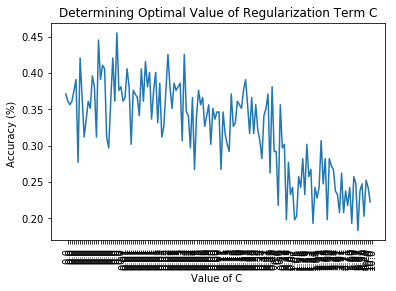

In [15]:
li = [np.arange(1,151)]
p = plt.plot(cost_accuracies)
plt.title("Determining Optimal Value of Regularization Term C")
plt.xlabel('Value of C ')
plt.ylabel('Accuracy (%) ')
costs_plot = np.around(c2,decimals=2)
plt.xticks(li[0],costs_plot, rotation=90)
plt.figure()

We were having trouble displaying the c values along the x axis so we displayed them below. 

In [16]:
print(c2)

[0.001, 0.001, 0.001, 0.0012067926406393288, 0.0012067926406393288, 0.0012067926406393288, 0.0014563484775012444, 0.0014563484775012444, 0.0014563484775012444, 0.0017575106248547913, 0.0017575106248547913, 0.0017575106248547913, 0.0021209508879201904, 0.0021209508879201904, 0.0021209508879201904, 0.0025595479226995358, 0.0025595479226995358, 0.0025595479226995358, 0.0030888435964774815, 0.0030888435964774815, 0.0030888435964774815, 0.0037275937203149379, 0.0037275937203149379, 0.0037275937203149379, 0.0044984326689694442, 0.0044984326689694442, 0.0044984326689694442, 0.0054286754393238594, 0.0054286754393238594, 0.0054286754393238594, 0.0065512855685955088, 0.0065512855685955088, 0.0065512855685955088, 0.0079060432109077008, 0.0079060432109077008, 0.0079060432109077008, 0.0095409547634999446, 0.0095409547634999446, 0.0095409547634999446, 0.011513953993264469, 0.011513953993264469, 0.011513953993264469, 0.013894954943731374, 0.013894954943731374, 0.013894954943731374, 0.0167683293681100

In [32]:
max_y = max(p[0].get_ydata())
d = {}
for pair in zip(c2,p[0].get_ydata()):
    d[pair[1]] = pair[0]
max_x = d[max_y]
print(max_x)


0.00449843266897


To further optimize the classifier, we plotted the sample values of the regularization parameter (0.001 - 10) against their respective accuracies and determined that there are usually two to three x regularization parameter values that would produce the highest accuracies. We found the c that produced the highest accuracy in the function above and use it to capture the performance of our "best" logistic regression optimization procedure below.

## Comparing our Best Logistic Regression Optimization Procedure to that of Scikit-Learn

In [18]:

lr_clf_accuracies = []
lr_clf_times = []
lr_clf_mem = []
lr_clf_iterations = []



mglr = MultiClassLogisticRegression(eta=0.1,iterations=10, C=max_x, optimization="BFGSBinaryLogisticRegression",reg=0) # get object

lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)])
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
with np.errstate(all='ignore'):
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

        st = time.time()

        mem = memory_usage((lr_clf.fit,(X_train,y_train))) # train object
        t = (time.time() -st)
        lr_clf_times.append(t)
        lr_clf_mem.append(mem[0])

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
        lr_clf_accuracies.append(acc)
        cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1
for x in range(0,15):
    lr_clf_iterations.append(2) 
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.376237623762
confusion matrix
 [[ 8  8  6  2  1]
 [ 9  8  9  5  0]
 [ 7 11 20 10  9]
 [ 0  7 10 14 18]
 [ 2  2  4  6 26]]
====Iteration 1  ====
accuracy 0.351485148515
confusion matrix
 [[ 7 12  7  3  0]
 [ 9 10 11  6  3]
 [ 3  6 19 15  6]
 [ 2  8 10  9 11]
 [ 1  4  1 13 26]]
====Iteration 2  ====
accuracy 0.415841584158
confusion matrix
 [[ 7  4  7  1  4]
 [ 9 11 10  5  2]
 [ 6  6 19  9  3]
 [ 1  5 12 17 17]
 [ 1  3  5  8 30]]


After testing various optimizations we determined our "best" logistic regression procedure would be BFGS with an eta of 0.1, 10 Iterations, L1 Regularization, and a C regularization parameter of 0.02 based off the highest accuracy in our plot.

In [19]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_sk = SKLogisticRegression(solver='lbfgs',class_weight='balanced',max_iter=500,C=0.002) 

lr_sk_accuracies = []
lr_sk_times = []
lr_sk_mem = []
lr_sk_iterations = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    st = time.time()
    mem = memory_usage((lr_sk.fit,(X_train,y_train)))
    #lr_sk.fit(X_train,y_train)
    t = (time.time() -st)
    lr_sk_times.append(t)
    lr_sk_mem.append(mem[0])
    #print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
    yhat = lr_sk.predict(X_test)
    print("Iterations ",lr_sk.n_iter_)
    lr_sk_iterations.append(lr_sk.n_iter_)
    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    lr_sk_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

print(lr_sk_times)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

Iterations  [ 69  22  33 173  71]
====Iteration 0  ====
accuracy 0.163366336634
confusion matrix
 [[ 0  0  0  0  0  0]
 [ 2  5  7  5 10  0]
 [ 5  8  7  5 13  0]
 [ 6  4  9 11 13  0]
 [ 4  6 14  9 10  0]
 [ 7  6 16 10 10  0]]
Iterations  [138  49  55  88 178]
====Iteration 1  ====
accuracy 0.178217821782
confusion matrix
 [[ 0  0  0  0  0  0]
 [ 5  2  8  4  7  0]
 [ 4  5  8  7  6  0]
 [ 5  8 13 14 12  0]
 [ 5  5 13  6 12  0]
 [ 5  9 11  9 19  0]]
Iterations  [212 101  47  87 191]
====Iteration 2  ====
accuracy 0.178217821782
confusion matrix
 [[ 0  0  0  0  0  0]
 [ 6  4  4  4  6  0]
 [ 5  6 11  5 14  0]
 [ 4  6 12 11 11  0]
 [ 5  6 12  9 10  0]
 [ 4  7 14 11 15  0]]
[0.36100220680236816, 0.28028416633605957, 0.3296501636505127]


For some reason, our scikit learn logistic regression optimization procedure has a row of zeros and a column of zeroes which we believe is most likely causing its low accuracy. 

## Visualizing Performance Differences in terms of Accuracy, Training Time, Training Iterations, and Memory Usage

498.4525203704834


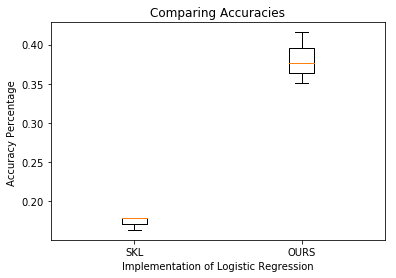

In [20]:
plt.boxplot([lr_sk_accuracies,lr_clf_accuracies])
plt.title("Comparing Accuracies")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Accuracy Percentage ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


We have higher accuracy in our implementation but this is expected as we did not perform PCA on the SKL implementation and SKL confusion matrices had columns and rows of 0s.

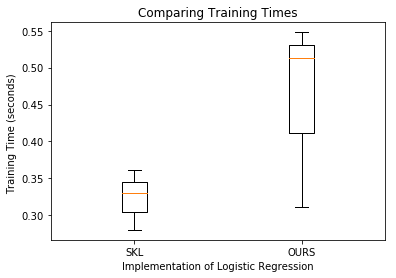

In [21]:
plt.boxplot([lr_sk_times,lr_clf_times])
plt.title("Comparing Training Times")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

Our best logistic regression optimization procedure's training time is 1.6 times greater than that of scikit learn's. 

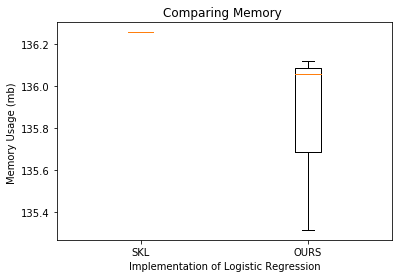

In [22]:
plt.boxplot([lr_sk_mem,lr_clf_mem])
plt.title("Comparing Memory ")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Memory Usage (mb) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

Our best logistic regression optimization procedure's strength is its memory usage. Its training memory usage is considerably less than that of scikit learn's. 

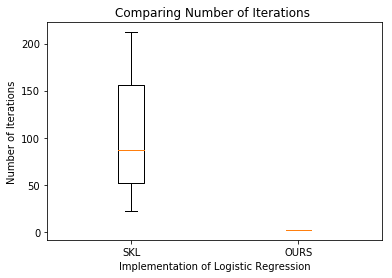

In [23]:
plt.boxplot([lr_sk_iterations,lr_clf_iterations])
plt.title("Comparing Number of Iterations ")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Number of Iterations')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

It was difficult to compare our implementation's number of iterations to that of scikit learn's because ours was consistently returning two, which is most likely incorrect. 

## Analyzing which implementation of Logistic Regression would be best for our case

While we have higher accuracy than sklearn's implementation of BFGS, we acknowledge that we may not have implemented it properly. Our implementation has flaws (such as not being able to return iterations) and has not been tested like sklearn's. Our implementation was slower than sklearn's. We realize we did not use PCA on sklearn's implementation. Once we went back and used the Pipeline object, we saw that it created errors in trying to track memory and iterations. This likely will greatly affect the accuracies between our implementations.

If we could improve our implementation we would recommend it (as it does use scipy) but since we know it has flaws and could not directly compare our implementations (due to PCA and Pipelining), we would recommend using sklearn's implementation.

## Exceptional Work

Below is our usage of our implementation of GridSearchCV. We chose a scoring for accuracy and used our BFGS implementation as our estimator. We want to find the best Cost value that GridSearchCV recommends and compare it with our decision.

In [24]:
with np.errstate(all='ignore'):
    param_grid_input = {'C': costs }
    mglr = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization="BFGSBinaryLogisticRegression")
    gscv = GridSearchCV(cv= cv_object, estimator=mglr, param_grid= param_grid_input, scoring= "accuracy",refit=False)
    gscv.fit(X,y)

{'C': 0.001}
{'C': 0.001}
{'C': 0.001}
{'C': 0.0012067926406393288}
{'C': 0.0012067926406393288}
{'C': 0.0012067926406393288}
{'C': 0.0014563484775012444}
{'C': 0.0014563484775012444}
{'C': 0.0014563484775012444}
{'C': 0.0017575106248547913}
{'C': 0.0017575106248547913}
{'C': 0.0017575106248547913}
{'C': 0.0021209508879201904}
{'C': 0.0021209508879201904}
{'C': 0.0021209508879201904}
{'C': 0.0025595479226995358}
{'C': 0.0025595479226995358}
{'C': 0.0025595479226995358}
{'C': 0.0030888435964774815}
{'C': 0.0030888435964774815}
{'C': 0.0030888435964774815}
{'C': 0.0037275937203149379}
{'C': 0.0037275937203149379}
{'C': 0.0037275937203149379}
{'C': 0.0044984326689694442}
{'C': 0.0044984326689694442}
{'C': 0.0044984326689694442}
{'C': 0.0054286754393238594}
{'C': 0.0054286754393238594}
{'C': 0.0054286754393238594}
{'C': 0.0065512855685955088}
{'C': 0.0065512855685955088}
{'C': 0.0065512855685955088}
{'C': 0.0079060432109077008}
{'C': 0.0079060432109077008}
{'C': 0.0079060432109077008}
{'C'

In [25]:
print(gscv.best_params_)

{'C': 0.40949150623804231}


Based on our graph above, "Determining Optimal Value of Regularization Term C", we chose C to be ____ . GridSearchCV recommends we use _ for C. These are not too different so we are confident in our choice. While implementing GridSearchCV functionality for our classes was difficult and would require further implementations, we conclude that it would be a better choice (once implemented) than having to graph values.